## Summary
Amyotrophic lateral sclerosis (ALS) is associated with progressive loss of motor neurons in the motor cortex and spinal cord.  Several mechanisms of neuronal death have been proposed; however, it is generally accepted that ALS is the end result of a deleterious interplay between genetic and environmental factors. Therefore, this interplay has multiple pathways modulated by complex underlying genetic factors.  With this project we aimed to identify mechanisms playing a role in the disease by studying gene expression data that result from the interaction of genetic and environmental factors. 
We had access to gene expression data from motor neurons that were derived from induced pluripotent stem cells generated from 137 ALS patients and 32 healthy controls. It is likely that the sample size of patients and/or controls limited our ability to find differences.

Next, we hypothesized that the differences in gene expression levels between subgroups of ALS patients could allow us to identify the pathway or mechanisms playing a role in the disease pathophysiology. To achieve this, we performed unsupervised hierarchical clustering to identify subgroups of patients with different gene expression profiles. We found two main clusters with multiple subdivisions, Cluster1 and Cluster2. 
 
After comparing the gene expression levels from Cluster1 to Cluster2 including sex, race and 5 differentiation markers as covariates, we identified 11366 genes that were differentially expressed after correcting for multiple testing (FDR<0.05). We then performed an overrepresentation pathways at Reactome (https://reactome.org/PathwayBrowser/#TOOL=AT) to identify the mechanisms in which these genes were involved stratifying by down- and up-regulated genes. The down-regulated genes are overrepresented significantly in multiple pathways (FILE). 

## Data analysis
In order to identify mechanisms that differ from ALS patients and healthy individuals we performed a differential expression analysis to identify genes whose expression was regulated differently. However, we did not identify significant differences. This analysis was underpower due to the limited sample size available in the study, however a larger sample size may lead to identification of relevant pathways. The analysis could also be affected by the heterogeneity present in the cohort, either by the batch effects or the different stages of cell development, although we corrected for it in our model. 

As the aim of our analysis was to capture the mechanism related to the ALS pathophysiology, we explored the data and removed the technical artifacts when possible. It is known that transcriptomic data is prone to batch defects and that the iPScells could introduce too much variability as they are  in diverse cell differentiation stages. Therefore, we made data exploration and normalization our priority.

We started working with the provided normalized DeSeq2 dataset. To assess the possible batch effects, we performed a Multidimensional scaling (MDS)  analysis. We observed two main clusters with overlapping cases and controls suggesting a possible technical issue.

In [15]:
# Load librarys
library('edgeR')
library('limma')
library('Glimma')
library('ggplot2')
library('RColorBrewer')
library('morpheus')
library('org.Hs.eg.db')
library("dplyr")
library("gplots")

In [16]:
# Explore control vs cases Data to kwnow what is the bestway  to process data
ctrl_vs_cases_transcrip_data <- read.csv('/home/jupyter/end-als/transcriptomics-data/DESeq2/ctrl_vs_case.csv')

In [17]:
# Getting ctrl vs case group
ctrl_vs_cases_group <- factor(ctrl_vs_cases_transcrip_data$CtrlVsCase_Classifier)
# Delete ctrl vs cases from original dataset 
ctrl_vs_cases_procces <- subset(ctrl_vs_cases_transcrip_data, select= -c(2))
# Transpose data to have id in columns
ctrl_vs_cases_procces <- t(ctrl_vs_cases_procces)
# Change the columns names for the ids
colnames(ctrl_vs_cases_procces) <- ctrl_vs_cases_procces[1, ]
# Delete  ids from the first row 
ctrl_vs_cases_procces <- ctrl_vs_cases_procces[-c(1), ]
# set rows names to add later to df
genes_names <- rownames(ctrl_vs_cases_procces)
ctrl_vs_cases_procces <- data.frame(ctrl_vs_cases_procces)
# changing the type data chart to numeric
ctrl_vs_cases_procces <- as.data.frame(sapply(ctrl_vs_cases_procces, as.numeric))
# Set row names genes to the new data colletion
rownames(ctrl_vs_cases_procces) <- genes_names

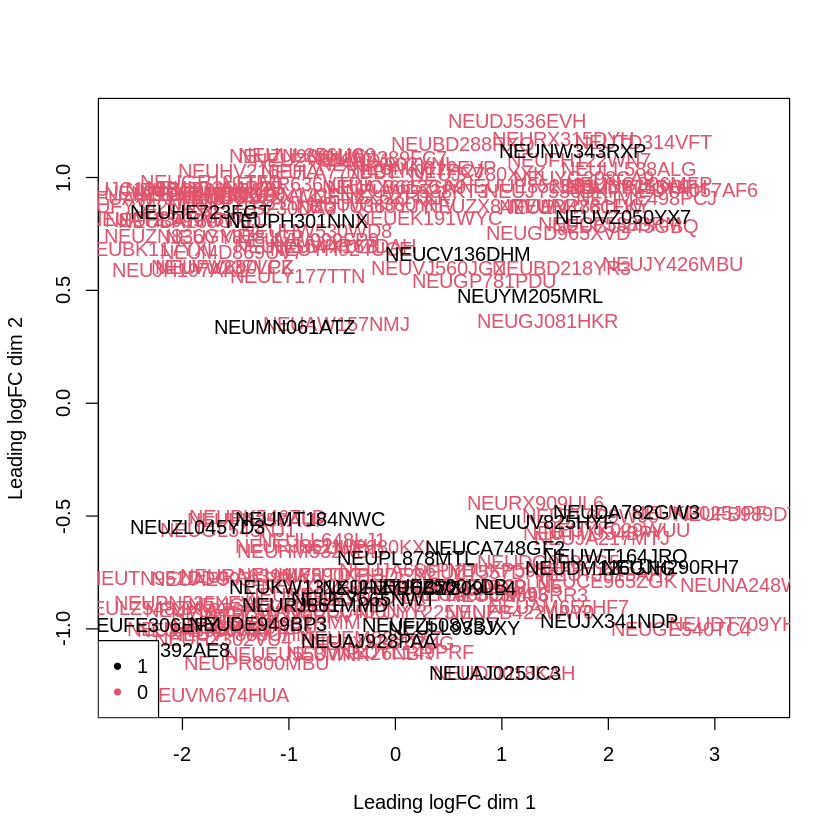

In [18]:
# DGEList to run MDS
ctrl_vs_cases_procces_dglist <- DGEList(counts = as.matrix(ctrl_vs_cases_procces), group = ctrl_vs_cases_group)
#plot MDS 
plotMDS(ctrl_vs_cases_procces_dglist, col=as.numeric(ctrl_vs_cases_procces_dglist$samples$group))
legend("bottomleft", as.character(unique(ctrl_vs_cases_procces_dglist$samples$group)), col=1:3, pch=20)


We then decided to look directly at the gene counts. To achieve this, we first extracted all the gene counts per patient from the different folders and created a matrix with gene counts. We excluded the control with ID CTRL-NEUEU392AE8 because this file containes 17 files into the folder.

In [19]:
# Reading principal path L3 counts data to extrac txt files
l3_count_main_path <- "/home/jupyter/end-als/transcriptomics-data/L3_counts"
# List of folder in L3_counts
l3_count_main_path_list <- list.files(path = l3_count_main_path)
# Declare variable just for concatenate txt files
all_transcriptomic_counts <- "Principal"
flag <- TRUE
for (folder in l3_count_main_path_list){
    # Get sub-folder path
    subfolder <- list.files(path=paste(l3_count_main_path, folder, sep='/'))
    # If the folder contains more than one file the is excluded
    if (length(subfolder) > 1){
        next
    }
    # Read last file this path contain the name of .txt file
    exon_txt_file <- list.files(path=paste(l3_count_main_path, folder, subfolder, sep='/'))
    # Concatenate all path to read csv
    complete_l3_count_path <- paste(l3_count_main_path, folder, subfolder, exon_txt_file, sep='/')
    
    # Reading exo.txt file
    l3_counts_per_id <- read.table(complete_l3_count_path, sep = "\t", header=TRUE)
    # Select genes columns and counts
    l3_counts_per_id <- subset(l3_counts_per_id, select=(c(1,7)))
    # Change the name of columns for genes for genes and counts per id
    colnames(l3_counts_per_id) <- c("genes", folder)
    # If is the first iterarion then enter into if and save file in all_transcript_count to by concacatenate later
    if(flag){
        flag<- FALSE
        all_transcriptomic_counts <- l3_counts_per_id
        next
    }
    # Join all count in single file
    all_transcriptomic_counts <- left_join(x = all_transcriptomic_counts, y = l3_counts_per_id, by = "genes", all.x = TRUE)
}
# Write csv file of raw counts
write.csv(all_transcriptomic_counts, "raw_L3counts_data.csv")

We then performed the normalization on the raw count matrix in edgeR. For this we removed genes with low reads and then generated a new MDS; continuing to observe heterogeneity.

In [20]:
# To performance MDS with color by case and ctrl is necesario get the groups from clinical data portal data
clinical_data_portal <- read.csv('/home/jupyter/end-als/clinical-data/filtered-metadata/metadata/aals_dataportal_datatable.csv')
# Creating dataframe just with data that we need
clinical_data_portal_subset <- data.frame(clinical_data_portal$Participant_ID, clinical_data_portal$Sex,
                                         clinical_data_portal$Race, clinical_data_portal$Subject.Group, 
                                         clinical_data_portal$Site.of.Onset, clinical_data_portal$NEFH..SMI32.,
                                         clinical_data_portal$ISL1, clinical_data_portal$`NKX6.1`, 
                                         clinical_data_portal$TUBB3..TuJ1., clinical_data_portal$s100b)
# Change col names
colnames(clinical_data_portal_subset) <- c("Participant_ID", "Sex", "Race", "SubjectGroup", "SiteOfOnset", "NEFH",
                                          "ISL1", "NKX6", "TUBB3", "s100b")
# Transpose data to join data portal and raw counts data
all_transcriptomic_counts_transpose <- t(all_transcriptomic_counts)
# Change the columns names for the ids
colnames(all_transcriptomic_counts_transpose) <- all_transcriptomic_counts_transpose[1, ]
# Delete  ids from the first row 
all_transcriptomic_counts_transpose <- data.frame(all_transcriptomic_counts_transpose[-c(1), ])
# set participant Id as columns
all_transcriptomic_counts_transpose$Participant_ID <- rownames(all_transcriptomic_counts_transpose)
# Join raw counts and data portal 
all_transcriptomic_counts_and_data_portal <- left_join(x = all_transcriptomic_counts_transpose, 
                                       y = clinical_data_portal_subset, by = "Participant_ID", all.x = TRUE)

# Save transcripts groups to use latter in Difererntial expression analysis
transcripts_groups <- all_transcriptomic_counts_and_data_portal[c("Participant_ID", "Sex", "Race", 
                                                                 "SubjectGroup", "SiteOfOnset", "NEFH",
                                                                 "ISL1", "NKX6", "TUBB3", "s100b")]

transcripts_groups$SubjectGroup[which(transcripts_groups$SubjectGroup != "Healthy Control")]  <- "ALS"
# Delete columns from raw counts
all_transcriptomic_counts_and_data_portal <- subset(all_transcriptomic_counts_and_data_portal, select=-c( Sex, Race, 
                                                                 SubjectGroup, SiteOfOnset, NEFH,
                                                                 ISL1, NKX6, TUBB3, s100b))



In [21]:
# report process to transpose data

# Transpose data to have id in columns
all_transcriptomic_counts_and_data_portal <- t(all_transcriptomic_counts_and_data_portal)
# Change the columns names for  ids patinets
colnames(all_transcriptomic_counts_and_data_portal) <- all_transcriptomic_counts_and_data_portal[60676, ]
# Delete  ids from the last row 
all_transcriptomic_counts_and_data_portal <- all_transcriptomic_counts_and_data_portal[-c(60676), ]
# Convert matrix to data frame
all_transcriptomic_counts_and_data_portal <- data.frame(all_transcriptomic_counts_and_data_portal)
# Set genes ids
genes_id <- rownames(all_transcriptomic_counts_and_data_portal)
# # changing the type data chart to numeric
all_transcriptomic_counts_and_data_portal <- as.data.frame(sapply(all_transcriptomic_counts_and_data_portal, as.numeric))
# Set row names genes to the new data colletion
rownames(all_transcriptomic_counts_and_data_portal) <- genes_id



In [22]:
dgelist_edgeR_normalize <- DGEList(counts = as.matrix(all_transcriptomic_counts_and_data_portal), group = transcripts_groups$SubjectGroup)
# Filter data by cpm
keep_data<- filterByExpr(dgelist_edgeR_normalize)
dgelist_edgeR_normalize<- dgelist_edgeR_normalize[keep_data, , keep.lib.sizes=FALSE]
# Normalize Data
edgeR_normalize_data <- calcNormFactors(dgelist_edgeR_normalize)
#edgeR_normalize_data <- logcpm <- cpm(edgeR_normalize_data, log=TRUE)
dgelist_edgeR_normalize <- DGEList(counts = as.matrix(edgeR_normalize_data), group = transcripts_groups$SubjectGroup)


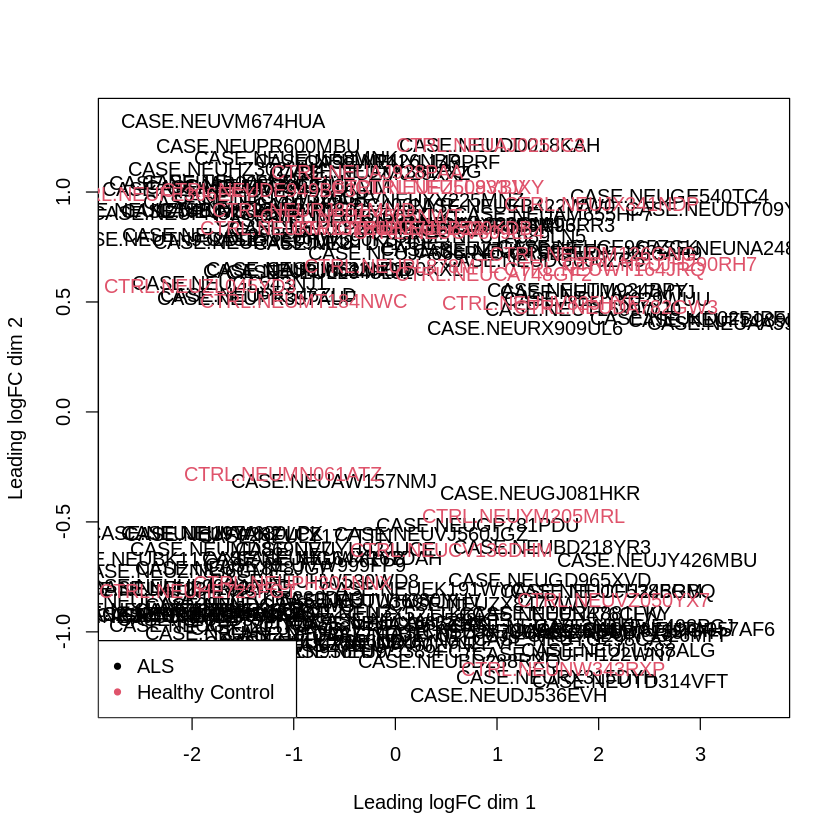

In [23]:
# plot MDS
plotMDS(dgelist_edgeR_normalize, col=as.numeric(dgelist_edgeR_normalize$samples$group))
legend("bottomleft", as.character(unique(dgelist_edgeR_normalize$samples$group)), col=1:3, pch=20)

As quartile normalization, followed by log transformation of the data has been suggested as a good approach to remove batch effects, we implemented it using limma. When we included all the genes, we saw a homogeneous model, but after removing the low count genes, we observed heterogeneity. We decided to use this data for further analysis including the staining markers for cell differentiation as covariates as suggested in one of the Kaggle discussions. We included sex and race as covariates, as they also affect gene expression. We wanted to include age, as it affects the transcriptomic profile, but this was not possible due to missing values in the data set.

In [24]:
# Filter just cases from raw data
all_transcriptomic_counts_and_data_portal <- all_transcriptomic_counts_and_data_portal [transcripts_groups$SubjectGroup == 'ALS']
transcripts_groups <- transcripts_groups[transcripts_groups$SubjectGroup == 'ALS', ]


In [25]:
# Calculate count per million and keep samples
cpm_quantile_transform <- cpm(all_transcriptomic_counts_and_data_portal)
# thresh_cpm to filter data
thresh_cpm <- cpm_quantile_transform > 0.5
keep_quantile_data <- rowSums(thresh_cpm) >= 2
counts.keep_quantile_data<- all_transcriptomic_counts_and_data_portal[keep_quantile_data,]
# Quantile normalization
quantile_normalization_data <-normalizeQuantiles(counts.keep_quantile_data, ties=TRUE)
# log transformation
log_quantile_norm_data <- log1p(quantile_normalization_data)
#created dglist to make MDS
dgelist_quantile_data <- DGEList(counts = as.matrix(log_quantile_norm_data), group = transcripts_groups$SubjectGroup)

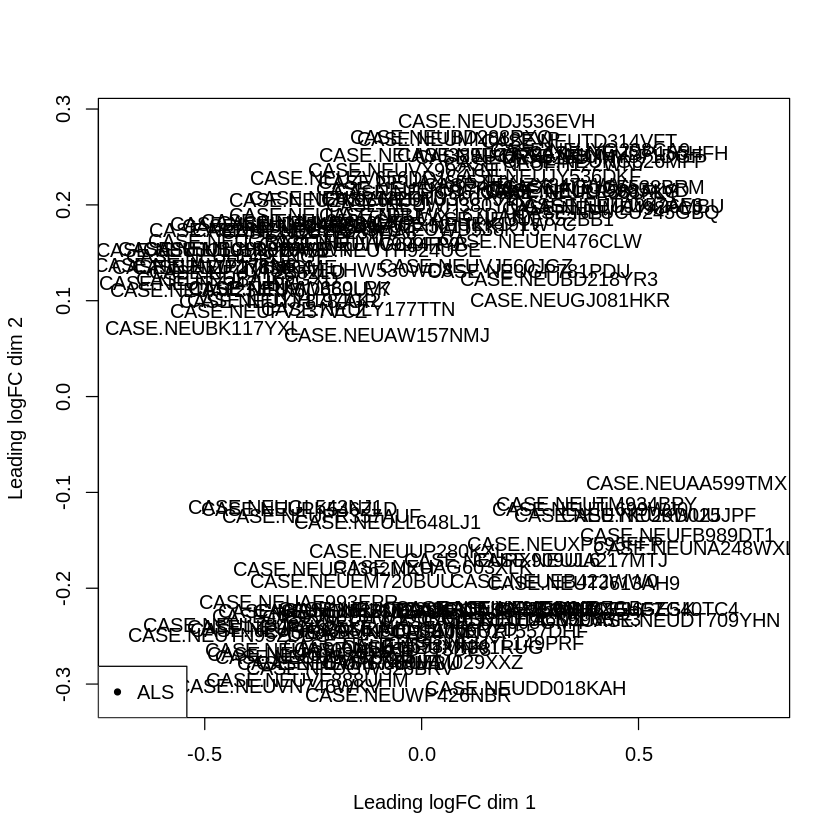

In [26]:
# plot MDS
plotMDS(dgelist_quantile_data, col=as.numeric(dgelist_quantile_data$samples$group))
legend("bottomleft", as.character(unique(dgelist_quantile_data$samples$group)), col=1:3, pch=20)

To identify subgroups of patients with different transcriptomic profiles we decided to follow an unsupervised clustering approach. However, for  this approach we needed to remove the heterogeneity in the data caused by the different differentiation stages of the iPS cells. We use the removeBatchEffect function in the limma package to correct for the staining markers. We included 5 out 6 markers as covariates, as Nestin had 38 missing values. We removed 11 cases and 2 cases for this analysis because they had missing values for the markers. After generating
an MDS plot, we did not observe any more heterogeneity in the data.


In [27]:
# Filter by markers
# it'is neccesary create boolean list of each marker to filter all missings values
# NEFH marker filter
NEFH_boolean_list <- !is.na(transcripts_groups$NEFH)
log_quantile_norm_data <- log_quantile_norm_data [NEFH_boolean_list]
transcripts_groups <- transcripts_groups[NEFH_boolean_list, ]
# ISL1 marker filter
ISL1_boolean_list <- !is.na(transcripts_groups$ISL1)
log_quantile_norm_data <- log_quantile_norm_data [ISL1_boolean_list]
transcripts_groups <- transcripts_groups[ISL1_boolean_list, ]
# NKX6 marker filter
NKX6_boolean_list <- !is.na(transcripts_groups$NKX6)
log_quantile_norm_data <- log_quantile_norm_data [NKX6_boolean_list]
transcripts_groups <- transcripts_groups[NKX6_boolean_list, ]
# TUBB3 marker filter
TUBB3_boolean_list <- !is.na(transcripts_groups$TUBB3)
log_quantile_norm_data <- log_quantile_norm_data [TUBB3_boolean_list]
transcripts_groups <- transcripts_groups[TUBB3_boolean_list, ]
# s100b marker filter
s100b_boolean_list <- !is.na(transcripts_groups$s100b)
log_quantile_norm_data <- log_quantile_norm_data [s100b_boolean_list]
transcripts_groups <- transcripts_groups[s100b_boolean_list, ]

In [28]:
# remove bath effect by markers
quantile_data_removeBatchEffect <- removeBatchEffect(log_quantile_norm_data, covariates=transcripts_groups[c("NEFH", "ISL1", "NKX6", "TUBB3", "s100b")])

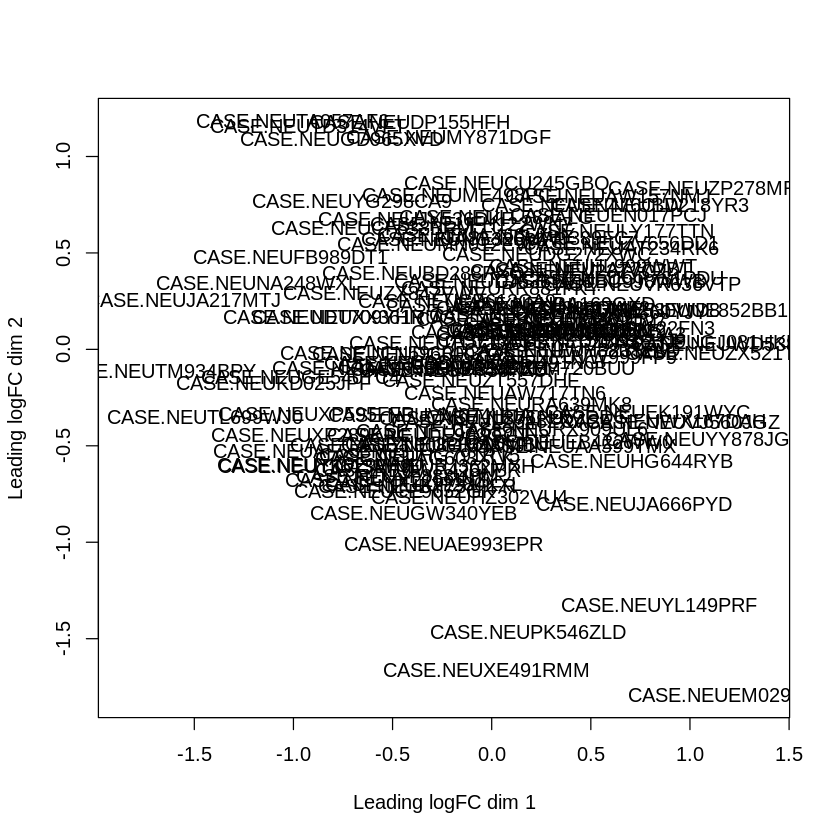

In [29]:
# Plot MDS After generating an MDS plot, we did not observe any more heterogeneity in the data.
plotMDS(quantile_data_removeBatchEffect)

We did not use this correction for the differential expression analysis as this function is not intended to be used prior to linear modelling. Thus, for the differential expression analysis we continued using the markers as covariates, but the data was used to genered heirarchical clustering.

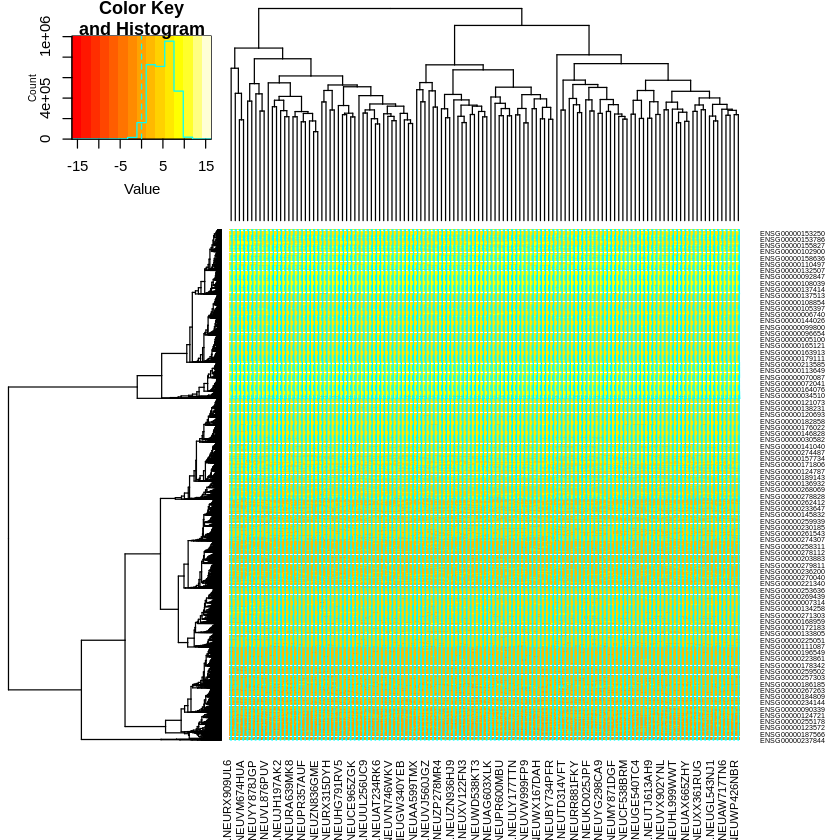

In [30]:
heatmap_corrected_data <- heatmap.2(quantile_data_removeBatchEffect, dendrogram='both', distfun = function(x) dist(x, method="euclidean"))

In the first level of the dendrogram, we observed two main clusters with multiple smaller clusters. After some trial and error with a different number of sub-clusters, we decided to focus on the two main groups. We extracted the individuals belonging to each cluster, Cluster1 has 79 individuals, while Cluster2 has 45. After running a linear model including the covariates, we found 11 366 genes that were differentially expressed after correcting for multiple testing (FDR<0.05).

In [41]:
hc <- as.hclust( heatmap_corrected_data$colDendrogram )
clusters <- cutree(hc, k=2 )
# clusters_corrected_data <
transcripts_groups$clusters <- clusters


In [42]:
# Diferential expression analisis
# Declare covariantes
NKX <- transcripts_groups$NEFH
NEFH <- transcripts_groups$ISL1
TUBB3 <- transcripts_groups$NKX6
ISL1 <- transcripts_groups$TUBB3
s100b <- transcripts_groups$s100b
sex <- transcripts_groups$Sex
race <- transcripts_groups$Race
clusters <- factor(transcripts_groups$clusters)

In [47]:
design_matrix <- model.matrix(~0 + clusters + NKX + NEFH + TUBB3 + ISL1 + s100b + race + sex )

colnames(design_matrix) <- c('clusters_one1', 'clusters_one2','NKX', 'NEFH', 'TUBB3', 'ISL1', 's100b',
                     'race1', 'race2',
                        'race3', 'rece4', 'sex') 


# fit data
fit_case_clusters <- lmFit(as.matrix(log_quantile_norm_data), design_matrix)
# contrast case vs control data
cont.matrix_cluster <- makeContrasts(clusters_one1-clusters_one2, levels = design_matrix)
fit_case_clusters <- contrasts.fit(fit_case_clusters, cont.matrix_cluster)
fit_case_clusters <- eBayes(fit_case_clusters)

#cluster1 vs all
DEP_SIG_ALS_cluster1_vs_cluster2 <- topTable(fit_case_clusters, adjust = "BH", coef = 1,
                                           number = length(fit_case_clusters$coefficients)) 
# Filter by  p.adjust.val
DEP_SIG_ALS_cluster1_vs_cluster2 <- DEP_SIG_ALS_cluster1_vs_cluster2[ DEP_SIG_ALS_cluster1_vs_cluster2$adj.P.Val < 0.05, ]
DEP_SIG_ALS_cluster1_vs_cluster2
# write.csv(DEP_SIG_ALS_cluster1_vs_all, 'cluster1_vs_cluster2_corrected.csv') # Cluster1VsAll

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000187266,-0.7319842,4.333843,-10.817124,3.423548e-19,8.441786e-15,33.00594
ENSG00000110721,0.3011387,6.969568,10.557194,1.387198e-18,1.710276e-14,31.65068
ENSG00000087116,-0.9908760,5.112909,-10.371300,3.773926e-18,3.101916e-14,30.68097
ENSG00000207460,-0.5458573,6.738172,-10.283254,6.062283e-18,3.737095e-14,30.22167
ENSG00000151490,0.4898680,7.763254,10.183450,1.037360e-17,5.115843e-14,29.70106
ENSG00000170469,-0.3650521,5.119455,-10.124105,1.427633e-17,5.524398e-14,29.39154
ENSG00000177685,-0.7238476,5.415446,-10.106641,1.568285e-17,5.524398e-14,29.30046
ENSG00000184185,-0.6695717,6.743966,-10.079749,1.812411e-17,5.586304e-14,29.16023
ENSG00000206688,-0.5945338,7.138567,-9.949625,3.649153e-17,9.997868e-14,28.48182


In order to extract the biological meaning of the identified genes, we performed overrepresentation analysis in Reactome (https://reactome.org/PathwayBrowser/#TOOL=AT). As input we introduced  separately the genes that were down and up regulated, and selected the option “Project to human” for the analysis. The output of the analysis including the overrepresented genes can be found in XXX and XXX files.

## Discussion
Our top priority was to identify the mechanism playing a role in the disease by comparing gene expression differences in ALS patients compared to controls. However, we did not observe any significant difference between ALS patients and controls after correcting for multiple testing. It is likely that this lack of differential gene expression was due to limitations in the sample size.

We identified two main subgroups or clusters of gene expression with several subdivisions.

Interestingly,  genes involved in L13a-mediated translational silencing of Ceruloplasmin expression are regulated differently in Cluster1 compared to Cluster2, suggesting a higher expression of ceruloplasmin in Cluster one compared to cluster2. Ceruloplasmin is known to be altered in neurological diseases, as ceruloplasmin is related to iron/copper metabolism, it is linked to neurologic symptoms and signs.
 
Selenocysteine synthesis is another pathway relevant to ALS, as it has been shown that the cerebrospinal fluid of ALS patients contains elevated levels of selenium species. A recent study suggests that these elevated levels result from mutations causing ALS, as they only observed this in a patient with a mutation in TUBA4A (Mandrioli Et al. Neurodegener Dis 2017;17:171-180). A further study comparing the genetic mutation from patients in Cluster1 with Cluster2 could help us to assess if there is indeed a genetic component involved in this pathway. 
 
Other pathways potentially related to ALS include Response of EIF2AK4 (GCN2) to amino acid deficiency showing different regulation in Cluster1 compared to Cluster 2 are  response of EIF2AK4 (GCN2) to amino acid deficiency, eukaryotic translation elongation and  endosomal/vacuolar pathway.

In conclusion, our results showed that ALS is being caused by multiple pathways. We observe 2 main subgroups in the gene expression data set. These results suggest that ALS results from multiple interactions of genes that alter multiple pathways that converge in the phenotype. Each of the clusters identified in this study can have different altered pathway subdivisions that may assist in designing new approaches to target drug development or in subtyping the disease.